## Resource Model metrics and comparisons

Work with Arches-based resource models (RM)

In [ ]:
Load libraries

In [1]:
import os
import urllib.request
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re

Load GitHub repository and requirements

In [2]:
# Download and install latest version of Arches graph parser
!rm cultural-heritage -R
!git clone https://github.com/achp-project/cultural-heritage.git
!pip install -r cultural-heritage/graph-parser/requirements.txt

rm: cannot remove 'cultural-heritage': No such file or directory
Cloning into 'cultural-heritage'...
remote: Enumerating objects: 1799, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1799 (delta 245), reused 172 (delta 157), pack-reused 1527
Receiving objects: 100% (1799/1799), 19.47 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (1158/1158), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.

List of available RMs

In [4]:
# Download uploaded cultural heritage partners graphs
remote_source_files = {
    "MAPSS": "https://raw.githubusercontent.com/achp-project/prj-mapss/main/pkg/graphs/Heritage%20Place%20(3).json",
    "MAHS": "https://raw.githubusercontent.com/achp-project/prj-mahs/main/Site.json",
    "MAHSA": "https://raw.githubusercontent.com/achp-project/prj-mahsa/main/resource-models/Heritage%20Location%20Resource%20Model.json",
    "MAEASAM": "https://raw.githubusercontent.com/achp-project/prj-maeasam/main/Site.json",
    "EAMENA": "https://raw.githubusercontent.com/achp-project/prj-eamena-marea/main/resource_models/Heritage%20Place.json",
}

Select two or more RMs to compare (checkoxes). Choose: MAHSA and EAMENA.

In [5]:
def generate_checkboxes_from_dict(input_dict):
    checkboxes = {key: widgets.Checkbox(description=key, value=False) for key in input_dict.keys()}
    return checkboxes
checkboxes_dict = generate_checkboxes_from_dict(remote_source_files)
def get_and_print_checked_values(**kwargs):
    checked_values = {key: value for key, value in kwargs.items() if isinstance(value, widgets.Checkbox) and value.value}
interactive_widget = interactive(get_and_print_checked_values, **checkboxes_dict)
display(interactive_widget)
print("Note: MAHSA and EAMENA have been hard coded below, please select these two ones")

interactive(children=(Checkbox(value=False, description='MAPSS'), Checkbox(value=False, description='MAHS'), C…

Note: MAHSA and EAMENA have been hard coded below, please select these two ones


Retrieve and show selected RM keys

In [6]:
selected_keys = []
for key, checkbox in checkboxes_dict.items():
    if checkbox.value:
        selected_keys.append(key)
print("Selected projects:", selected_keys)
if len(selected_keys) < 2:
    print("Please select a minimum of two different JSON files")
else:
    subset_remote_source_files = {}
    # Iterate through the selected keys and add corresponding key-value pairs to the subset dictionary
    for key in selected_keys:
        if key in remote_source_files:
            subset_remote_source_files[key] = remote_source_files[key]
    print("Selected RMs:", subset_remote_source_files)

!rm inputResourceModels -R
!mkdir -p inputResourceModels

for (project_name, resource_model_url) in subset_remote_source_files.items():
  target_filename = f"{project_name}_{resource_model_url.split('/')[-1]}"
  # print(target_filename)
  urllib.request.urlretrieve(resource_model_url, filename=f"inputResourceModels/{target_filename}")

Selected projects: ['MAHSA', 'EAMENA']
Selected RMs: {'MAHSA': 'https://raw.githubusercontent.com/achp-project/prj-mahsa/main/resource-models/Heritage%20Location%20Resource%20Model.json', 'EAMENA': 'https://raw.githubusercontent.com/achp-project/prj-eamena-marea/main/resource_models/Heritage%20Place.json'}
rm: cannot remove 'inputResourceModels': No such file or directory


Create subgraph and comparison dataframe csv files by running [graph-parser.py](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/graph_parser.py) and [graph-comparator.py](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/graph_comparator.py)

In [7]:
!python cultural-heritage/graph-parser/graph_comparator.py -d -m list -o subgraphMetrics.csv inputResourceModels/*.json
!python cultural-heritage/graph-parser/graph_comparator.py -d -m compare -o comparisonMetrics.csv inputResourceModels/*.json
# Generate pandas Dataframes from csv
subgraph_metrics = pd.read_csv('subgraphMetrics.csv')
comparison_metrics = pd.read_csv('comparisonMetrics.csv')

Show subgraph metrics (see: [documentation](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/README.md#minimal_subgraph_data))

In [10]:
subgraph_metrics = pd.read_csv('subgraphMetrics.csv')
col_order = ['G', 'source', 'target', 'property', 'source_id', 'target_id', 'weight']
subgraph_metrics.rename(columns={'graph_name': 'G', 'source_property': 'source', 'target_property': 'target', 'relation_type': 'property'}, inplace=True)
subgraph_metrics['weight'] = 1
subgraph_metrics['source_id'] = subgraph_metrics['source'] + '_' + subgraph_metrics['G']
subgraph_metrics['target_id'] = subgraph_metrics['target'] + '_' + subgraph_metrics['G']
subgraph_metrics = subgraph_metrics[col_order]
subgraph_metrics

array(['EAMENA_Heritage%20Place',
       'MAHSA_Heritage%20Location%20Resource%20Model'], dtype=object)

Compararison metrics (see: [documentation](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/README.md#graph_comparison_data))

In [11]:
comparison_metrics = pd.read_csv('comparisonMetrics.csv')
comparison_metrics.rename(columns={'graph_name': 'G', 'source_property': 'source', 'target_property': 'target', 'relation_type': 'property'}, inplace=True)
comparison_metrics['weight'] = 2
comparison_metrics['G'] = 'both' # comparison_metrics['graph_name_1'] + "_x_" + comparison_metrics['graph_name_2']
comparison_metrics['source_id'] = comparison_metrics['source'] + '_' + comparison_metrics['G']
comparison_metrics['target_id'] = comparison_metrics['target'] + '_' + comparison_metrics['G']
comparison_metrics = comparison_metrics[col_order]
comparison_metrics

,G,source,target,property,source_id,target_id,weight
0,both,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_both,E60_Number_both,2
1,both,E3_Condition_State,E5_Event,O14i_is_initialized_by,E3_Condition_State_both,E5_Event_both,2
2,both,E16_Measurement,E55_Type,P2_has_type,E16_Measurement_both,E55_Type_both,2
3,both,E13_Attribute_Assignment,E52_Time-Span,P4_has_time-span,E13_Attribute_Assignment_both,E52_Time-Span_both,2
4,both,E16_Measurement,E54_Dimension,P40_observed_dimension,E16_Measurement_both,E54_Dimension_both,2
5,both,E53_Place,E55_Type,P2_has_type,E53_Place_both,E55_Type_both,2
6,both,E52_Time-Span,E61_Time_Primitive,P82a_begin_of_the_begin,E52_Time-Span_both,E61_Time_Primitive_both,2
7,both,E53_Place,E44_Place_Appellation,P87_is_identified_by,E53_Place_both,E44_Place_Appellation_both,2
8,both,E13_Attribute_Assignment,E55_Type,P141_assigned,E13_Attribute_Assignment_both,E55_Type_both,2
9,both,E52_Time-Span,E61_Time_Primitive,P82b_end_of_the_end,E52_Time-Span_both,E61_Time_Primitive_both,2


Concatenation of subgraphs and comparison metrics

In [78]:
df_all_match = pd.concat([subgraph_metrics, comparison_metrics])
df_all_match = df_all_match.drop_duplicates()
df_all_match

<class 'pandas.core.frame.DataFrame'>


,G,source,target,property,source_id,target_id,weight
0,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,1
2,EAMENA_Heritage%20Place,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_EAMENA_Heritage%20Place,E60_Number_EAMENA_Heritage%20Place,1
5,EAMENA_Heritage%20Place,E14_Condition_Assessment,E14_Condition_Assessment,P117i_includes,E14_Condition_Assessment_EAMENA_Heritage%20Place,E14_Condition_Assessment_EAMENA_Heritage%20Place,1
6,EAMENA_Heritage%20Place,E28_Conceptual_Object,E13_Attribute_Assignment,P17i_motivated,E28_Conceptual_Object_EAMENA_Heritage%20Place,E13_Attribute_Assignment_EAMENA_Heritage%20Place,1
9,EAMENA_Heritage%20Place,E13_Attribute_Assignment,E46_Section_Definition,P141_assigned,E13_Attribute_Assignment_EAMENA_Heritage%20Place,E46_Section_Definition_EAMENA_Heritage%20Place,1
...,...,...,...,...,...,...,...
14,both,E13_Attribute_Assignment,I2_Belief,P141_assigned,E13_Attribute_Assignment_both,I2_Belief_both,2
15,both,E13_Attribute_Assignment,E55_Type,P2_has_type,E13_Attribute_Assignment_both,E55_Type_both,2
16,both,E13_Attribute_Assignment,E39_Actor,P14_carried_out_by,E13_Attribute_Assignment_both,E39_Actor_both,2
17,both,E41_Appellation,E55_Type,P2_has_type,E41_Appellation_both,E55_Type_both,2


### Graphs

Functions for graphs

In [13]:
# test unique
a = df_all_match['G'].unique()
print(sorted(a))
'both' in a

['EAMENA_Heritage%20Place', 'MAHSA_Heritage%20Location%20Resource%20Model', 'both']


True

In [57]:
node_size = 200
font_size = 10
edge_width = .5
fig_dim = 10
node_color = "#add8e6" # lightblue

def create_graph(rm):
  condition = df_all_match['G'] == rm
  df_G = df_all_match[condition]
  G = nx.from_pandas_edgelist(df_G, 'source_id', 'target_id', True, create_using=nx.DiGraph())
  G_attrs_nodes = {}
  # clean
  rm_ = '_' + rm
  for i, node in enumerate(G.nodes()):
    a = re.sub(rm_, '', node)
    G_attrs_nodes[node] = {'entity': a, 'G': rm}
  nx.set_node_attributes(G, G_attrs_nodes)
  return(G)

def edges_labels(dict):
    newdict = {}
    for ed, value in dict.items():
      # short the name
      val = re.sub(r'_.*', '',  value)
      newdict[ed] = val
    return(newdict)

def nodes_labels(dict):
    newdict = {}
    for node, value in dict.items():
      # short the name
      val = re.sub(r'_.*', '',  value)
      newdict[node] = val
    return(newdict)

def plot_G(digraph):
  p = nx.circular_layout(digraph)
  labels_nodes = nx.get_node_attributes(digraph, 'entity')
  labels_nodes = nodes_labels(labels_nodes)
  labels_edges = nx.get_edge_attributes(digraph, 'property')
  labels_edges = edges_labels(labels_edges)
  plt.figure(figsize = (fig_dim + 6, fig_dim - 1))
  nx.draw(digraph, pos = p, labels = labels_nodes, with_labels = True, node_size = node_size, node_color = node_color, font_size = font_size, width = edge_width)
  nx.draw_networkx_edge_labels(digraph, pos = p, edge_labels = labels_edges, font_size = font_size)
  plt.show()

Plot individual graphs and store them in a list

EAMENA_Heritage%20Place


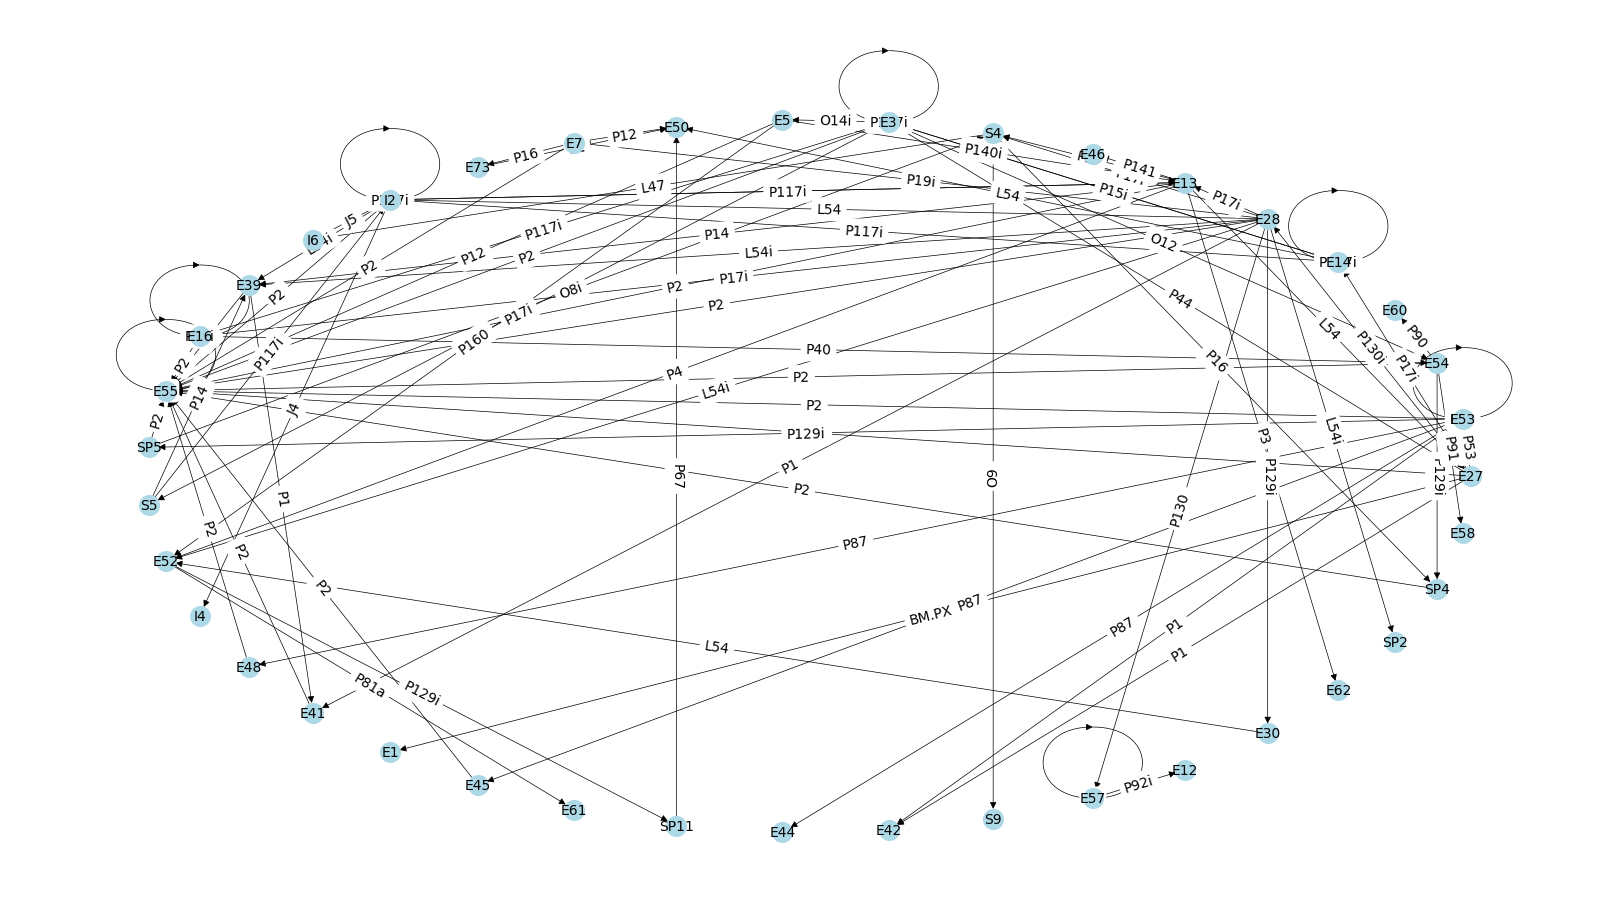

MAHSA_Heritage%20Location%20Resource%20Model


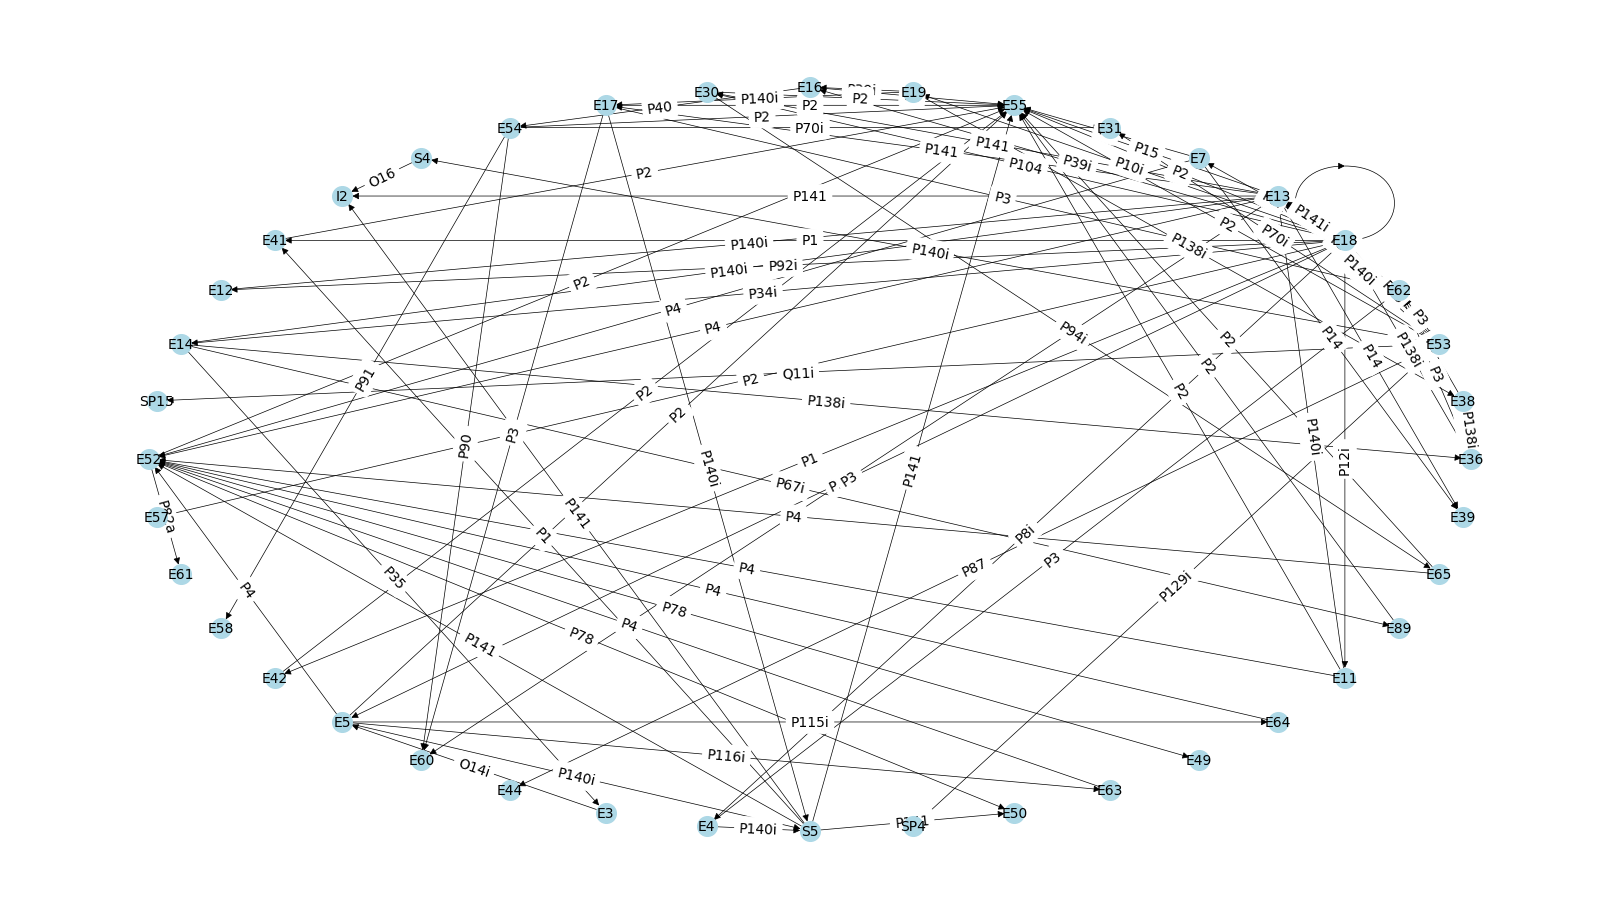

In [83]:
graph_list = []
a = df_all_match['G'].unique()
a = a.tolist()
a.remove('both')
for i in a:
  print(i)
  G = create_graph(i)
  graph_list.append(G)
  plot_G(G)

Tag the dataframe



In [84]:
# df_all_match = pd.concat([subgraph_metrics, comparison_metrics])
rows_to_duplicate = df_all_match[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')]

# find indices of 'both' rows
idx_both = df_all_match.index[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_match
df_all_both['both'] = '0'
# search and replace
for both in idx_both:
	df_both_1 = df_all_both.loc[[both]]
	df_both_1['both'] = str(both) + "_1"
	df_both_1['source_id'] = df_both_1.iloc[0]['source_id'].replace('both', '1')
	df_both_1['target_id'] = df_both_1.iloc[0]['target_id'].replace('both', '1')
	df_both_2 = df_all_both.loc[[both]]
	df_both_2['source_id'] = df_both_2.iloc[0]['source_id'].replace('both', '2')
	df_both_2['target_id'] = df_both_2.iloc[0]['target_id'].replace('both', '2')
	df_both_2['both'] = str(both) + "_1"
	df_all_both = pd.concat([df_all_both, df_both_1], ignore_index=True)
	df_all_both = pd.concat([df_all_both, df_both_2], ignore_index=True)
# remove rows with 'both' patterns
idx_both = df_all_both.index[df_all_both['source_id'].str.contains('_both') | df_all_both['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_both.drop(idx_both)
df_all_both

,G,source,target,property,source_id,target_id,weight,both
0,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,1,0
1,EAMENA_Heritage%20Place,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_EAMENA_Heritage%20Place,E60_Number_EAMENA_Heritage%20Place,1,0
2,EAMENA_Heritage%20Place,E14_Condition_Assessment,E14_Condition_Assessment,P117i_includes,E14_Condition_Assessment_EAMENA_Heritage%20Place,E14_Condition_Assessment_EAMENA_Heritage%20Place,1,0
3,EAMENA_Heritage%20Place,E28_Conceptual_Object,E13_Attribute_Assignment,P17i_motivated,E28_Conceptual_Object_EAMENA_Heritage%20Place,E13_Attribute_Assignment_EAMENA_Heritage%20Place,1,0
4,EAMENA_Heritage%20Place,E13_Attribute_Assignment,E46_Section_Definition,P141_assigned,E13_Attribute_Assignment_EAMENA_Heritage%20Place,E46_Section_Definition_EAMENA_Heritage%20Place,1,0
...,...,...,...,...,...,...,...,...
242,EAMENA_Heritage%20Place,E13_Attribute_Assignment,E52_Time-Span,P4_has_time-span,E13_Attribute_Assignment_EAMENA_Heritage%20Place,E52_Time-Span_EAMENA_Heritage%20Place,1,16_1
243,EAMENA_Heritage%20Place,I2_Belief,I4_Proposition_Set,J4_that,I2_Belief_EAMENA_Heritage%20Place,I4_Proposition_Set_EAMENA_Heritage%20Place,1,17_1
244,EAMENA_Heritage%20Place,I2_Belief,I4_Proposition_Set,J4_that,I2_Belief_EAMENA_Heritage%20Place,I4_Proposition_Set_EAMENA_Heritage%20Place,1,17_1
245,EAMENA_Heritage%20Place,E53_Place,E48_Place_Name,P87_is_identified_by,E53_Place_EAMENA_Heritage%20Place,E48_Place_Name_EAMENA_Heritage%20Place,1,18_1


Merge nodes (`dn_all` for *dataframe of nodes*)

In [106]:
merged_graph = nx.compose_all(graph_list)
data = {node: merged_graph.nodes[node] for node in merged_graph.nodes}
dn_all = pd.DataFrame.from_dict(data, orient = "index")
dn_all.reset_index(inplace = True)
dn_all.rename(columns={"index": "Node"}, inplace = True)
dn_all

,Node,entity,G
0,E27_Site_EAMENA_Heritage%20Place,E27_Site,EAMENA_Heritage%20Place
1,E53_Place_EAMENA_Heritage%20Place,E53_Place,EAMENA_Heritage%20Place
2,E54_Dimension_EAMENA_Heritage%20Place,E54_Dimension,EAMENA_Heritage%20Place
3,E60_Number_EAMENA_Heritage%20Place,E60_Number,EAMENA_Heritage%20Place
4,E14_Condition_Assessment_EAMENA_Heritage%20Place,E14_Condition_Assessment,EAMENA_Heritage%20Place
...,...,...,...
74,E64_End_of_Existence_MAHSA_Heritage%20Location...,E64_End_of_Existence,MAHSA_Heritage%20Location%20Resource%20Model
75,E11_Modification_MAHSA_Heritage%20Location%20R...,E11_Modification,MAHSA_Heritage%20Location%20Resource%20Model
76,E89_Propositional_Object_MAHSA_Heritage%20Loca...,E89_Propositional_Object,MAHSA_Heritage%20Location%20Resource%20Model
77,E65_Creation_MAHSA_Heritage%20Location%20Resou...,E65_Creation,MAHSA_Heritage%20Location%20Resource%20Model


Create a `match` column

In [107]:
dn_all_match = dn_all
dn_all_match.rename(columns={"Node": "match"}, inplace = True)
dn_all_match['id'] = range(len(dn_all_match))
dn_all_match['id'] = dn_all_match['id'] + 1
dn_all_match = dn_all_match.drop(['entity'], axis = 1)
dn_all_match

,match,G,id
0,E27_Site_EAMENA_Heritage%20Place,EAMENA_Heritage%20Place,1
1,E53_Place_EAMENA_Heritage%20Place,EAMENA_Heritage%20Place,2
2,E54_Dimension_EAMENA_Heritage%20Place,EAMENA_Heritage%20Place,3
3,E60_Number_EAMENA_Heritage%20Place,EAMENA_Heritage%20Place,4
4,E14_Condition_Assessment_EAMENA_Heritage%20Place,EAMENA_Heritage%20Place,5
...,...,...,...
74,E64_End_of_Existence_MAHSA_Heritage%20Location...,MAHSA_Heritage%20Location%20Resource%20Model,75
75,E11_Modification_MAHSA_Heritage%20Location%20R...,MAHSA_Heritage%20Location%20Resource%20Model,76
76,E89_Propositional_Object_MAHSA_Heritage%20Loca...,MAHSA_Heritage%20Location%20Resource%20Model,77
77,E65_Creation_MAHSA_Heritage%20Location%20Resou...,MAHSA_Heritage%20Location%20Resource%20Model,78


Merge G1 and G2 by duplicating the rows belonging to `both` RMs, add new ids (`id_source`, `id_target`) as IDs of nodes

In [112]:
rows_to_duplicate = df_all_match[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')]

# find indices of 'both' rows
idx_both = df_all_match.index[df_all_match['source_id'].str.contains('_both') | df_all_match['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_match
df_all_both['both'] = '0'
# search and replace
for both in idx_both:
	df_both_1 = df_all_both.loc[[both]]
	df_both_1['both'] = str(both) + "_1"
	df_both_1['source_id'] = df_both_1.iloc[0]['source_id'].replace('both', '1')
	df_both_1['target_id'] = df_both_1.iloc[0]['target_id'].replace('both', '1')
	df_both_2 = df_all_both.loc[[both]]
	df_both_2['source_id'] = df_both_2.iloc[0]['source_id'].replace('both', '2')
	df_both_2['target_id'] = df_both_2.iloc[0]['target_id'].replace('both', '2')
	df_both_2['both'] = str(both) + "_1"
	df_all_both = pd.concat([df_all_both, df_both_1], ignore_index=True)
	df_all_both = pd.concat([df_all_both, df_both_2], ignore_index=True)

# remove rows with 'both' patterns
idx_both = df_all_both.index[df_all_both['source_id'].str.contains('_both') | df_all_both['target_id'].str.contains('_both')].tolist()
df_all_both = df_all_both.drop(idx_both)

# common graph
df_both_source = df_all_both.merge(dn_all_match, right_on=['match'], left_on=['source_id'])
df_both_source = df_both_source.rename(columns={'id': 'id_source'})
df_both = df_both_source.merge(dn_all_match, right_on=['match'], left_on=['target_id'])
df_both = df_both.rename(columns={'id': 'id_target'})
# remove unuseful columns
df_both = df_both.drop(['G_y', 'G', 'match_x', 'match_y'], axis = 1)
df_both = df_both.rename(columns={'G_x': 'G'})
df_both

,G,source,target,property,source_id,target_id,weight,both,id_source,id_target
0,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,1,0,1,2
1,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,1,0_1,1,2
2,both,E54_Dimension,E60_Number,P90_has_value,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,2,0_1,1,2
3,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,1,0_1,1,2
4,both,E54_Dimension,E60_Number,P90_has_value,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place,2,0_1,1,2
...,...,...,...,...,...,...,...,...,...,...
223,MAHSA_Heritage%20Location%20Resource%20Model,E4_Period,S5_Inference_Making,P140i_was_attributed_by,E4_Period_MAHSA_Heritage%20Location%20Resource...,S5_Inference_Making_MAHSA_Heritage%20Location%...,1,0,69,70
224,MAHSA_Heritage%20Location%20Resource%20Model,E17_Type_Assignment,S5_Inference_Making,P140i_was_attributed_by,E17_Type_Assignment_MAHSA_Heritage%20Location%...,S5_Inference_Making_MAHSA_Heritage%20Location%...,1,0,52,70
225,MAHSA_Heritage%20Location%20Resource%20Model,E14_Condition_Assessment,E89_Propositional_Object,P67i_is_referred_to_by,E14_Condition_Assessment_MAHSA_Heritage%20Loca...,E89_Propositional_Object_MAHSA_Heritage%20Loca...,1,0,58,77
226,MAHSA_Heritage%20Location%20Resource%20Model,E14_Condition_Assessment,E3_Condition_State,P35_has_identified,E14_Condition_Assessment_MAHSA_Heritage%20Loca...,E3_Condition_State_MAHSA_Heritage%20Location%2...,1,0,58,68


In [ ]:
boths = df_both['both'].unique().tolist()
boths.remove('0')

for i in boths:
	# get the first one only, the second will be replaced
	both_row_to_keep  = df_both.index[df_both['both'] == i].tolist()[0]
	id_source_to_keep = df_both.iloc[both_row_to_keep]['id_source']
	id_target_to_keep = df_both.iloc[both_row_to_keep]['id_target']
	# collect the ids of the second one
	both_row_to_change  = df_both.index[df_both['both'] == i].tolist()[1]
	id_source_to_change = df_both.iloc[both_row_to_change]['id_source']
	id_target_to_change = df_both.iloc[both_row_to_change]['id_target']
	# replace ids 'to_change' by ids 'to_keep'
	# replace with the source
	df_both['id_source'] = df_both['id_source'].replace([id_source_to_change], id_source_to_keep)
	df_both['id_target'] = df_both['id_target'].replace([id_source_to_change], id_source_to_keep)
	# replace with the target
	df_both['id_source'] = df_both['id_source'].replace([id_target_to_change], id_target_to_keep)
	df_both['id_target'] = df_both['id_target'].replace([id_target_to_change], id_target_to_keep)
df_both

Plot G1 and G2

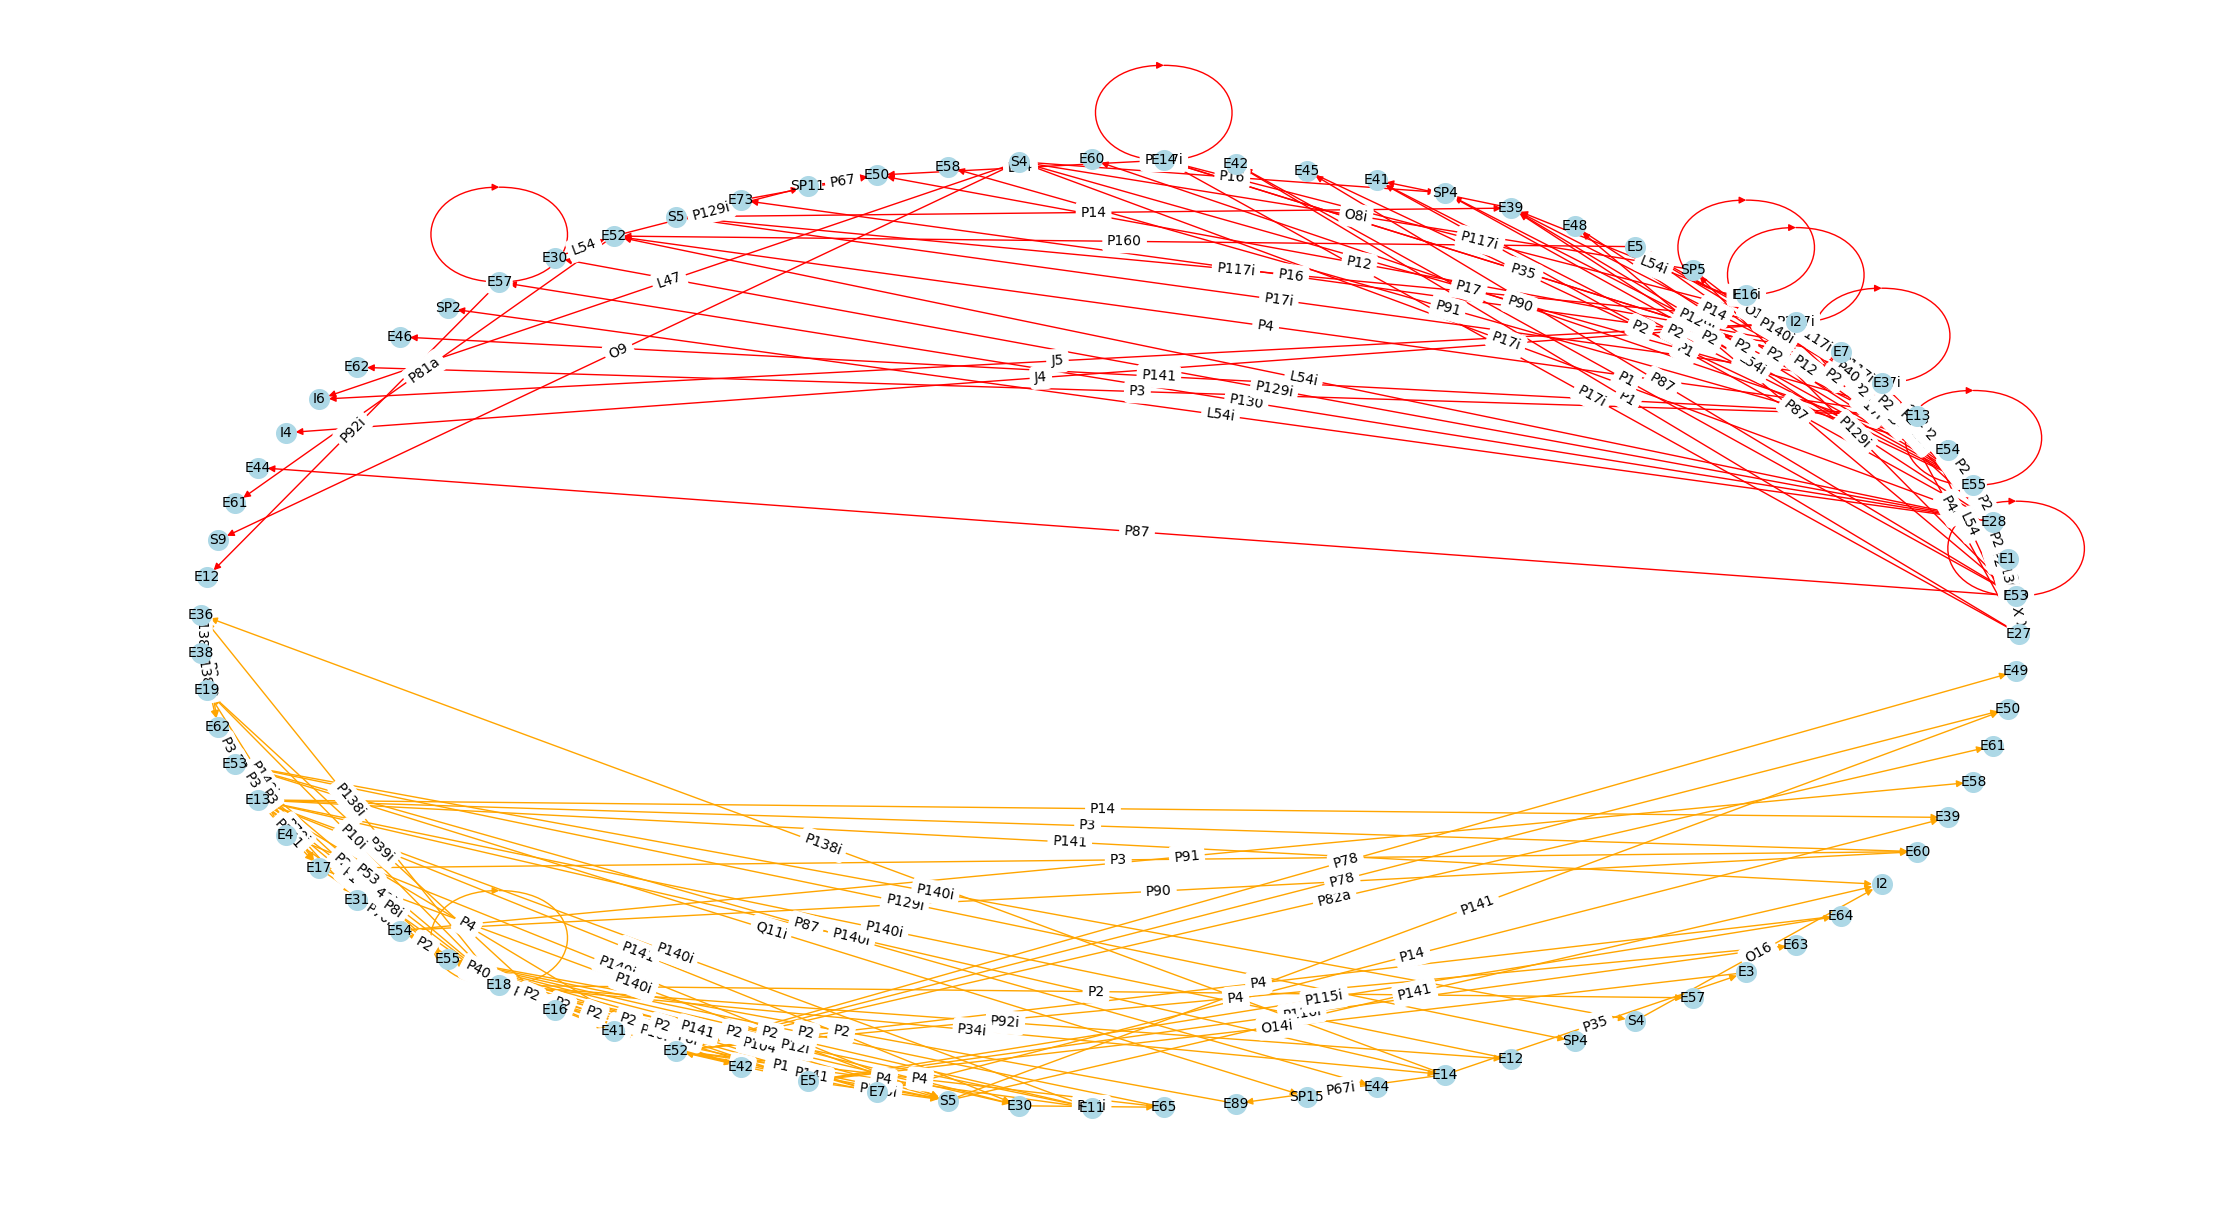

In [148]:
# assign colors
boths = df_both['G'].unique().tolist()
boths.remove('both')
boths.append('both')
colors = ['green', 'red', 'yellow', 'blue', 'purple']
colors = colors[0:len(boths)-1]
colors.append('black')
df = pd.DataFrame(list(zip(boths, colors)),
               columns =['G', 'color'])
df_both.merge(df, left_on='G', right_on='G')

# load with attributes
G = nx.from_pandas_edgelist(df_both, 'id_source', 'id_target', True, create_using=nx.DiGraph())
for i in G.nodes():
     G.nodes[i]['entity'] = dn_all[dn_all['id']==i]['entity'].item()

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

p = nx.circular_layout(G)
labels_nodes = nx.get_node_attributes(G, 'entity')
labels_nodes = nodes_labels(labels_nodes)
labels_edges = nx.get_edge_attributes(G, 'property')
labels_edges = edges_labels(labels_edges)
plt.figure(figsize = (fig_dim + 12, fig_dim + 2))
nx.draw(G, pos=p, labels = labels_nodes, with_labels = True, node_size = node_size, node_color = node_color, font_size = font_size, edge_color=colors, width=weights)
nx.draw_networkx_edge_labels(G, pos=p, edge_labels = labels_edges)
plt.show()

In [ ]:
# TODO
# Plot it in an interactive window, see: https://pyvis.readthedocs.io/en/latest/tutorial.html?highlight=jupyter#using-pyvis-within-jupyter-notebook

# !pip install pyvis
import pyvis
from pyvis import network as net

# errors, see: https://stackoverflow.com/questions/74945655/dataspell-outputs-the-following-error-local-cdn-resources-have-problems-on-chro
g = net.Network(notebook = True, cdn_resources='remote')
nxg = nx.complete_graph(5)
g.from_nx(nxg)
g.show("example.html")

example.html


example.html
